In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose
import timm
import cv2
import os
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torchvision import transforms as T
from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher
import seaborn as sns
from itertools import cycle

# Set random seed for reproducibility
RANDOM_SEED = 2025
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Utility function for device setup
def check_set_gpu(override=None):
    if override == None:
        # Prioritize CUDA, then MPS, then CPU
        if torch.cuda.is_available():
            device = torch.device('cuda')
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
            print(f"Using MPS: {torch.backends.mps.is_available()}")
        else:
            device = torch.device('cpu')
            print(f"Using CPU: {torch.device('cpu')}")
    else:
        device = torch.device(override)
    return device

# Set device
device = check_set_gpu() # Re-initialize device

Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [25]:
class MakananIndo(Dataset):
    # normalisasi ImageNet
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    def __init__(self,
                 data_dir='./train',
                 img_size=(224, 224),
                 transform=None,
                 split='train'
                 ):

        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        self.split = split

        csv_path = os.path.join(os.path.dirname(data_dir), 'train.csv')
        df = pd.read_csv(csv_path)

        df_filtered = df.dropna(subset=['label'])
        image_files_raw = df_filtered['filename'].astype(str).values.tolist()
        labels_raw = df_filtered['label'].astype(str).values.tolist()

        combined_data_raw = sorted(list(zip(image_files_raw, labels_raw)))

        self.data = []
        for filename, label in combined_data_raw:
            img_path = os.path.join(self.data_dir, filename)
            if os.path.exists(img_path):
                temp_img = cv2.imread(img_path)
                if temp_img is not None:
                    self.data.append((filename, label))
                else:
                    print(f"Warning: Could not read image file {img_path}. Skipping.")
            else:
                print(f"Warning: Image file not found at {img_path}. Skipping.")

        self.image_files = [item[0] for item in self.data]
        self.labels = [item[1] for item in self.data]

        self.default_transform = Compose([
            ToTensor(),
            Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.data[idx][0])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image could not be loaded at {img_path}. This should ideally be caught during initialization.")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)

        if self.transform:
            image = self.transform(image)
        else:
            image = self.default_transform(image)

        label = self.data[idx][1]

        return image, label, img_path

def create_label_encoder(dataset):
    """Create a mapping from string labels to numeric indices"""
    all_labels = []
    for i in range(len(dataset)):
        _, label, _ = dataset[i]
        all_labels.append(label)

    unique_labels = sorted(list(set(all_labels)))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    idx_to_label = {idx: label for idx, label in enumerate(unique_labels)}

    return label_to_idx, idx_to_label, unique_labels

def train_one_epoch(model, dataloader, criterion, optimizer, device, label_to_idx):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (inputs, labels_tuple, _) in enumerate(pbar):
        inputs = inputs.to(device)

        if isinstance(labels_tuple, (tuple, list)):
            if isinstance(labels_tuple[0], str):
                label_indices = [label_to_idx[label] for label in labels_tuple]
            else:
                label_indices = labels_tuple
            targets = torch.tensor(label_indices, dtype=torch.long).to(device)
        else:
            targets = torch.tensor(labels_tuple, dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_postfix({
            'loss': total_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })

    return total_loss/len(dataloader), 100.*correct/total

def validate(model, dataloader, criterion, device, label_to_idx):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch_idx, (inputs, labels_tuple, _) in enumerate(pbar):
            inputs = inputs.to(device)

            if isinstance(labels_tuple, (tuple, list)):
                if isinstance(labels_tuple[0], str):
                    label_indices = [label_to_idx[label] for label in labels_tuple]
                else:
                    label_indices = labels_tuple
                targets = torch.tensor(label_indices, dtype=torch.long).to(device)
            else:
                targets = torch.tensor(labels_tuple, dtype=torch.long).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_postfix({
                'loss': total_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })

    return total_loss/len(dataloader), 100.*correct/total


print("Starting model training...")



Starting model training...


In [ ]:
# Hyperparameter
num_epochs = 10
batch_size = 32
learning_rate = 0.01
img_size = (256, 256)

# Augmentasi agresif untuk train, ringan untuk val
train_transform = Compose([
    T.ToPILImage(),
    T.RandomResizedCrop(img_size[0], scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    ToTensor(),
    Normalize(mean=MakananIndo.IMAGENET_MEAN, std=MakananIndo.IMAGENET_STD),
])

val_transform = Compose([
    ToTensor(),
    Normalize(mean=MakananIndo.IMAGENET_MEAN, std=MakananIndo.IMAGENET_STD),
])

print("Loading full dataset with updated image size...")
Data_dir = os.path.join("IF25-4041-dataset", "train")
full_dataset = MakananIndo(
    data_dir=Data_dir,
    img_size=img_size,
    transform=None,
    split='train'
)
print(f"Total dataset size: {len(full_dataset)}")

# Train/val split
val_ratio = 0.2
num_full = len(full_dataset)
num_val = int(num_full * val_ratio)
num_train = num_full - num_val

train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val])
print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

# Set transform per split
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Label encoder dari train saja
label_to_idx, idx_to_label, unique_labels = create_label_encoder(train_dataset)
num_classes = len(unique_labels)
print(f"Number of classes: {num_classes}")

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("Initializing pre-trained DeiT-Small-Distilled (deit_small_distilled_patch16_224)...")
try:
    model = timm.create_model(
        'deit_small_distilled_patch16_224',
        pretrained=True,
        img_size=img_size[0],     # 256
        num_classes=num_classes   
    )
except RuntimeError as e:
    if "Unknown model" in str(e):
        print(f"Error: {e}. The model name 'deit_small_distilled_patch16_224' is not recognized by your timm version.")
        available_models = timm.list_models('*deit_small*')
        if available_models:
            print("Available DeiT small models:")
            for mm in available_models:
                print(f"- {mm}")
        raise
    else:
        raise

model = model.to(device)

# (opsional) freeze backbone: hanya head yang di-train
for name, p in model.named_parameters():
    if not name.startswith("head"):
        p.requires_grad = False

print(f"DeiT model initialized with custom classifier for {num_classes} classes.")
print(f"Model initialized and moved to device: {device}")

# Test forward
dummy_input = torch.randn(batch_size, 3, img_size[0], img_size[1]).to(device)
with torch.no_grad():
    out = model(dummy_input)
    print("Output shape after forward pass:", out.shape)  # harus [batch_size, num_classes]

print("Configuring loss function and optimizer...")
criterion = nn.CrossEntropyLoss()

# Hanya parameter yang requires_grad=True (head) yang dioptimasi
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(parameters, lr=1e-3, weight_decay=0.05)
print("Loss function and optimizer configured successfully.")

best_val_acc = -1
best_model_path = os.path.join('IF25-4041-dataset', 'DeiT_model.pth')

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, label_to_idx)
    val_loss, val_acc = validate(model, val_loader, criterion, device, label_to_idx)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'label_to_idx': label_to_idx,
            'idx_to_label': idx_to_label,
            'num_classes': num_classes
        }, best_model_path)
        print(f"Model saved to {best_model_path} with improved validation accuracy: {best_val_acc:.2f}%")

print("\nTraining complete!")
print(f"Best Validation Accuracy achieved: {best_val_acc:.2f}%")

Loading full dataset with updated image size...
Total dataset size: 1162
Train size: 930, Val size: 232
Number of classes: 5
Initializing pre-trained DeiT-Small-Distilled (deit_small_distilled_patch16_224)...
DeiT model initialized with custom classifier for 5 classes.
Model initialized and moved to device: cuda
Output shape after forward pass: torch.Size([32, 5])
Configuring loss function and optimizer...
Loss function and optimizer configured successfully.

Epoch 1/10


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.451, acc=89.2]


Epoch 1 - Train Loss: 0.7609, Train Acc: 76.24% | Val Loss: 0.4507, Val Acc: 89.22%
Model saved to C:/Users/mnauf/Downloads/IF25-4041-dataset/besto_model.pth with improved validation accuracy: 89.22%

Epoch 2/10


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.07it/s, loss=0.309, acc=93.5]


Epoch 2 - Train Loss: 0.2921, Train Acc: 93.55% | Val Loss: 0.3088, Val Acc: 93.53%
Model saved to C:/Users/mnauf/Downloads/IF25-4041-dataset/besto_model.pth with improved validation accuracy: 93.53%

Epoch 3/10


Validation: 100%|██████████| 8/8 [00:04<00:00,  1.84it/s, loss=0.244, acc=95.3]


Epoch 3 - Train Loss: 0.2016, Train Acc: 95.27% | Val Loss: 0.2445, Val Acc: 95.26%
Model saved to C:/Users/mnauf/Downloads/IF25-4041-dataset/besto_model.pth with improved validation accuracy: 95.26%

Epoch 4/10


Validation: 100%|██████████| 8/8 [00:04<00:00,  1.94it/s, loss=0.231, acc=95.7]


Epoch 4 - Train Loss: 0.1568, Train Acc: 97.31% | Val Loss: 0.2310, Val Acc: 95.69%
Model saved to C:/Users/mnauf/Downloads/IF25-4041-dataset/besto_model.pth with improved validation accuracy: 95.69%

Epoch 5/10


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s, loss=0.225, acc=96.6]


Epoch 5 - Train Loss: 0.1224, Train Acc: 98.06% | Val Loss: 0.2250, Val Acc: 96.55%
Model saved to C:/Users/mnauf/Downloads/IF25-4041-dataset/besto_model.pth with improved validation accuracy: 96.55%

Epoch 6/10


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s, loss=0.199, acc=96.6]


Epoch 6 - Train Loss: 0.1027, Train Acc: 98.92% | Val Loss: 0.1992, Val Acc: 96.55%

Epoch 7/10


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.11it/s, loss=0.195, acc=96.6]


Epoch 7 - Train Loss: 0.0898, Train Acc: 99.35% | Val Loss: 0.1950, Val Acc: 96.55%

Epoch 8/10


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.01it/s, loss=0.187, acc=97]   


Epoch 8 - Train Loss: 0.0810, Train Acc: 99.46% | Val Loss: 0.1874, Val Acc: 96.98%
Model saved to C:/Users/mnauf/Downloads/IF25-4041-dataset/besto_model.pth with improved validation accuracy: 96.98%

Epoch 9/10


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.03it/s, loss=0.183, acc=97]   


Epoch 9 - Train Loss: 0.0681, Train Acc: 99.46% | Val Loss: 0.1829, Val Acc: 96.98%

Epoch 10/10


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s, loss=0.179, acc=97]   

Epoch 10 - Train Loss: 0.0574, Train Acc: 99.35% | Val Loss: 0.1785, Val Acc: 96.98%

Training complete!
Best Validation Accuracy achieved: 96.98%


In [27]:
from sklearn.metrics import classification_report

print("\nEvaluating on validation set for detailed metrics...")
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels_tuple, _ in val_loader:
        inputs = inputs.to(device)

        # encode label string -> index (pakai label_to_idx yang sudah ada)
        if isinstance(labels_tuple, (tuple, list)):
            if isinstance(labels_tuple[0], str):
                label_indices = [label_to_idx[l] for l in labels_tuple]
            else:
                label_indices = labels_tuple
            targets = torch.tensor(label_indices, dtype=torch.long)
        else:
            targets = torch.tensor(labels_tuple, dtype=torch.long)

        outputs = model(inputs)
        _, preds = outputs.max(1)

        all_labels.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# urutkan label index supaya koheren
class_indices = sorted(idx_to_label.keys())
target_names = [idx_to_label[i] for i in class_indices]

print("\n=== Classification Report (Validation) ===")
print(classification_report(
    all_labels,
    all_preds,
    labels=class_indices,
    target_names=target_names,
    digits=4
))



Evaluating on validation set for detailed metrics...

=== Classification Report (Validation) ===
              precision    recall  f1-score   support

       bakso     0.9762    1.0000    0.9880        41
   gado_gado     0.9500    0.9500    0.9500        40
 nasi_goreng     0.9825    0.9655    0.9739        58
     rendang     0.9762    0.9318    0.9535        44
   soto_ayam     0.9608    1.0000    0.9800        49

    accuracy                         0.9698       232
   macro avg     0.9691    0.9695    0.9691       232
weighted avg     0.9700    0.9698    0.9697       232



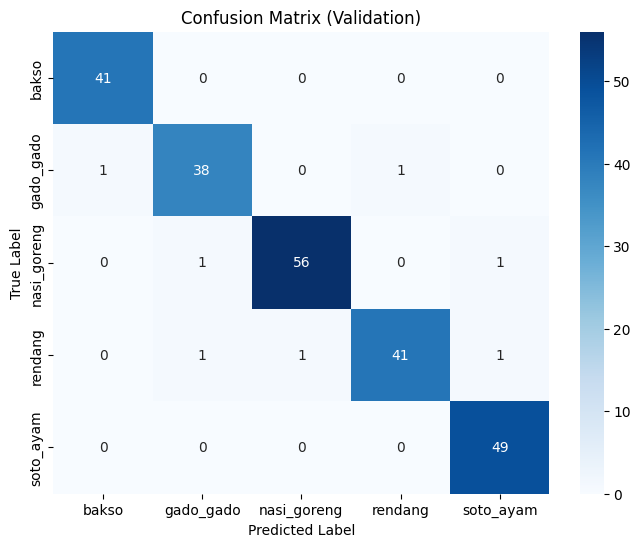

In [ ]:
# Kumpulkan prediksi di split validation
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels_tuple, _ in val_loader:
        inputs = inputs.to(device)
        if isinstance(labels_tuple, (tuple, list)):
            if isinstance(labels_tuple[0], str):
                label_indices = [label_to_idx[l] for l in labels_tuple]
            else:
                label_indices = labels_tuple
            targets = torch.tensor(label_indices, dtype=torch.long)
        else:
            targets = torch.tensor(labels_tuple, dtype=torch.long)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_labels.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Nama kelas
class_indices = sorted(idx_to_label.keys())
class_names = [idx_to_label[i] for i in class_indices]

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation)")
plt.show()


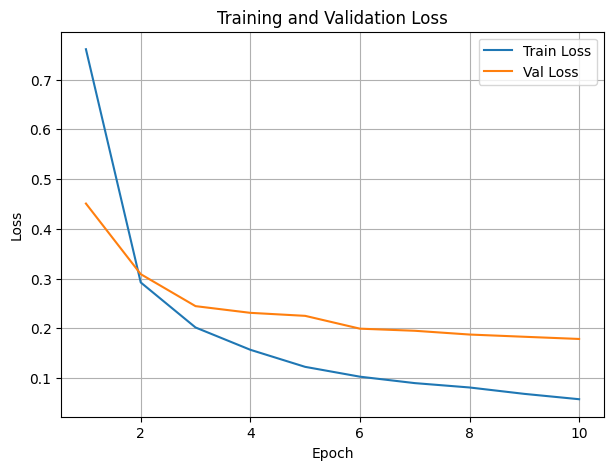

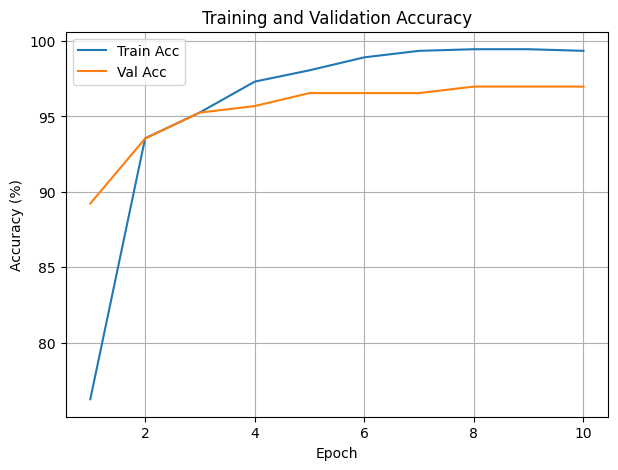

In [30]:
# Plot Loss
plt.figure(figsize=(7,5))
plt.plot(range(1, num_epochs+1), train_loss_history, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(7,5))
plt.plot(range(1, num_epochs+1), train_acc_history, label="Train Acc")
plt.plot(range(1, num_epochs+1), val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [32]:
# --- Parameter statistics ---
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
nontrainable_params = total_params - trainable_params

# Asumsi float32: 4 byte per parameter
model_size_mb = total_params * 4 / (1024**2)

print("\n=== Model Parameter Statistics ===")
print(f"Total parameters        : {total_params:,}")
print(f"Trainable parameters    : {trainable_params:,}")
print(f"Non-trainable parameters: {nontrainable_params:,}")
print(f"Approx. model size      : {model_size_mb:.2f} MB")
print("=================================\n")




=== Model Parameter Statistics ===
Total parameters        : 21,693,322
Trainable parameters    : 3,850
Non-trainable parameters: 21,689,472
Approx. model size      : 82.75 MB



In [ ]:
# Pastikan model di eval mode
model.eval()

# Nonaktifkan grad
def benchmark_inference(model, dataloader, device,
                        min_images=100, warmup_batches=5):
    model.to(device)
    model.eval()

    times = []
    n_images = 0

    with torch.no_grad():
        # WARM-UP: beberapa batch pertama tidak dihitung
        it = iter(dataloader)
        for _ in range(warmup_batches):
            try:
                inputs, _, _ = next(it)
            except StopIteration:
                return None  # data terlalu sedikit
            inputs = inputs.to(device)
            _ = model(inputs)

        # PENGUKURAN: loop sampai minimal min_images
        while n_images < min_images:
            try:
                inputs, _, _ = next(it)
            except StopIteration:
                # restart iterator kalau habis
                it = iter(dataloader)
                inputs, _, _ = next(it)

            inputs = inputs.to(device)

            torch.cuda.synchronize() if device.type == "cuda" else None
            t0 = time.time()
            _ = model(inputs)
            torch.cuda.synchronize() if device.type == "cuda" else None
            t1 = time.time()

            elapsed = t1 - t0
            times.append(elapsed)
            n_images += inputs.size(0)

    times = np.array(times)
    # waktu per gambar (detik)
    time_per_image = times / batch_size
    mean_ms = time_per_image.mean() * 1000.0
    std_ms = time_per_image.std(ddof=1) * 1000.0

    print(f"Images measured : {n_images}")
    print(f"Mean latency    : {mean_ms:.4f} ms / image")
    print(f"Std latency     : {std_ms:.4f} ms / image")

    return mean_ms, std_ms

# Panggil setelah training / load model
benchmark_inference(model, train_loader, device,
                    min_images=100, warmup_batches=5)


Images measured : 128
Mean latency    : 3.1923 ms / image
Std latency     : 0.0349 ms / image


(np.float64(3.1922589987516403), np.float64(0.03492184032054615))